<a href="https://colab.research.google.com/github/KauaHenSilva/python_predict_stock_prices/blob/main/main_mult_said.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recuperação por download

In [32]:
# @markdown #### Caso escolheu o tipo de recuperação drive/ambos e não tenha os arquivos, faça um atalho desse drive:
link_do_drive = "https://drive.google.com/drive/folders/1uwHnZRnVPt6ha5s_cyZSAoCP7ATWBEwN?usp=drive_link" #@param {type:"string"}
path_atalho_drive = "/content/drive/MyDrive/Projetos Do GitHub/python_predict_stock_prices" #@param {type:"string"}
path_download = "python_predict_stock_prices" #@param {type:"string"}

In [33]:
import os
import zipfile

if os.path.exists('python_download_file_drive'):
  !cd python_download_file_drive && git pull
else:
  !git clone https://github.com/KauaHenSilva/python_download_file_drive
%pip install --upgrade --quiet -r python_download_file_drive/requirements.txt


Already up to date.


In [34]:
try:
    from google.colab import drive
    from google.colab import auth
    from googleapiclient.discovery import build
    auth.authenticate_user()

    !python "python_download_file_drive/main.py" {link_do_drive} {path_download} # ALERTA: Caso o drive bote limite de download comente essa linha

    drive.mount('/content/drive')
    if not os.path.exists(path_atalho_drive):
      print("[INFO] Atalho no drive não encontrado.")

except:

    if os.path.exists(f"{path_download}.zip"):
      print(f"Descompactando {path_download}.zip")
      !rm -rf {path_download}
      with zipfile.ZipFile(f"{path_download}.zip", 'r') as zip_ref:
        zip_ref.extractall(f"{path_download}_temp")
        !mv {path_download}_temp/* {path_download}
        !rm -rf {path_download}_temp
        !rm -rf {path_download}.zip

    if not os.path.exists(path_download):
      raise Exception(f"Você não está nos altenticado nos servidores do google colab. Para prosseguir, faça o download dos arquivos que estão presente no drive e tente novamente. O link do drive {link_do_drive}. A pasta deve está dentro de /content/")


In [35]:
def get_referencia_valida(path, file_init):
    path_download = os.path.join(f"/content/{file_init}", path)
    path_drive = os.path.join(path_atalho_drive, path)

    bool_download = os.path.exists(path_download)
    bool_drive = os.path.exists(path_drive)

    if not bool_download and not bool_drive:
        raise Exception(f"Arquivo não encontrado em nenhum dos caminhos (Download ou Drive). Caminhos: {path_download}, {path_drive}")

    if not bool_drive and bool_download:
        print("[INFO] Arquivo encontrado no download, mas não no drive.")
        return path_download

    if bool_drive and not bool_download:
        print("[INFO] Arquivo encontrado no drive, mas não no download.")
        return path_drive

    return path_download


# Bolsa de valores

In [36]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

In [37]:
np.__version__, pd.__version__, matplotlib.__version__, tf.__version__, sklearn.__version__

('1.26.4', '2.2.2', '3.8.0', '2.16.1', '1.6.0')

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import  MinMaxScaler
import matplotlib.pyplot as plt

In [39]:
path_database_test = get_referencia_valida("petr4_teste.csv", path_download)
path_database_treinamento = get_referencia_valida("petr4_treinamento.csv", path_download)

[INFO] Arquivo encontrado no download, mas não no drive.
[INFO] Arquivo encontrado no download, mas não no drive.


In [40]:
database_treinamento = pd.read_csv(path_database_treinamento)
database_treinamento = database_treinamento.dropna()

In [41]:
base_treinamento = database_treinamento.iloc[:, 1:2].values
base_valor_maximo = database_treinamento.iloc[:, 2:3].values

In [42]:
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_valor_maximo_normalizado = normalizador.fit_transform(base_valor_maximo)

In [43]:
x = np.array([base_treinamento_normalizada[i-90:i, 0] for i in range(90, len(base_treinamento_normalizada))])
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [44]:
y1 = np.array([base_treinamento_normalizada[i, 0] for i in range(90, len(base_treinamento_normalizada))])
y2 = np.array([base_valor_maximo_normalizado[i, 0] for i in range(90, len(base_treinamento_normalizada))])
y = np.column_stack((y1, y2))

In [45]:
x.shape, y.shape

((1152, 90, 1), (1152, 2))

In [48]:
net = Sequential()

net.add(InputLayer(shape=(x.shape[1], 1)))
net.add(LSTM(units=100, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50))
net.add(Dropout(0.3))

net.add(Dense(units=2, activation='linear'))

net.summary();

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 90, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 90, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,502 (435.55 KB)

 Trainable params: 111,502 (435.55 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
net.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [56]:
mcp = ModelCheckpoint(filepath='pesos.keras', monitor='loss', save_best_only=True, verbose=True)

In [57]:
net.fit(x, y, epochs=100, batch_size=32, callbacks=[mcp]);

Epoch 1/100
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0033 - mean_absolute_error: 0.0443
Epoch 1: loss improved from inf to 0.00293, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0032 - mean_absolute_error: 0.0440 
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031 - mean_absolute_error: 0.0428
Epoch 2: loss did not improve from 0.00293
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031 - mean_absolute_error: 0.0428
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028 - mean_absolute_error: 0.0399
Epoch 3: loss improved from 0.00293 to 0.00282, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - mean_absolute_error: 0.0399
Epoch 4/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026 - mean_absolute_error: 0.0386
Epoch 4: loss improved from 0.00282 to 0.00279, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - mean_absolute_error: 0.0387
Epo

In [66]:
database_test = pd.read_csv(path_database_test)

In [67]:
y_open = database_test.iloc[:, 1:2].values
y_high = database_test.iloc[:, 2:3].values

In [68]:
base_completa = pd.concat((database_treinamento['Open'], database_test['Open']), axis=0)
entradas = base_completa[len(base_completa) - len(database_test) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

In [69]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [70]:
previsoes = net.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [71]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_open.ravel(), previsoes[:,0]))
print(mean_absolute_error(y_high.ravel(), previsoes[:,1]))

0.35440709077037447
0.42607715953480124


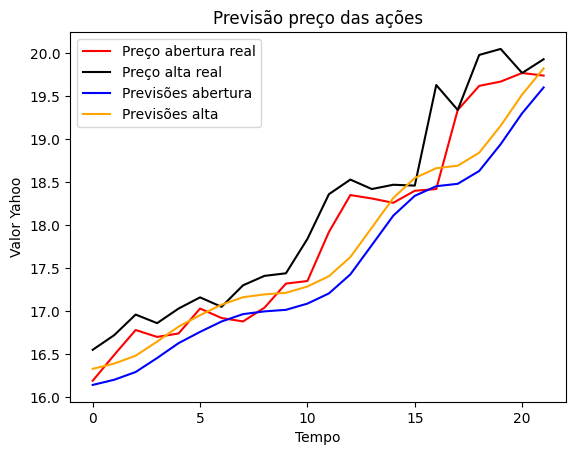

In [72]:
plt.plot(y_open, color = 'red', label = 'Preço abertura real')
plt.plot(y_high, color = 'black', label = 'Preço alta real')

plt.plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
plt.plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')

plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend();